In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
ds = xr.open_dataset('/g/data/er8/users/cd3022/solar_drought/GCCSA/2GMEL/2020/05//2GMEL_solar-pv_2020-05-02.nc')

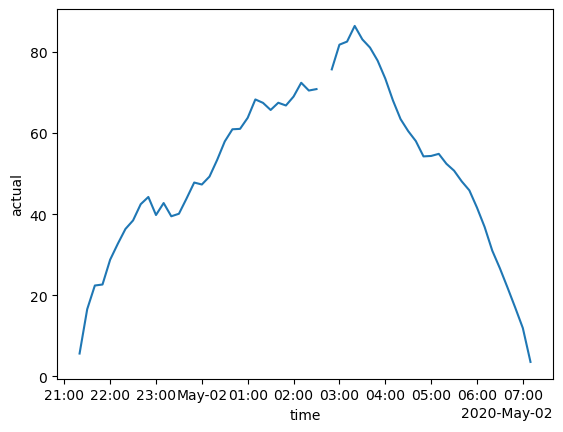

In [8]:
ds.actual.plot()

In [10]:
variables = ['actual', 'ideal'] # REZs
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/')

region_darrays = {}

for var in variables:
    file_path = base_path / var
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[var] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds = xr.Dataset(region_darrays)
ds = ds.load()

time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

In [38]:
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

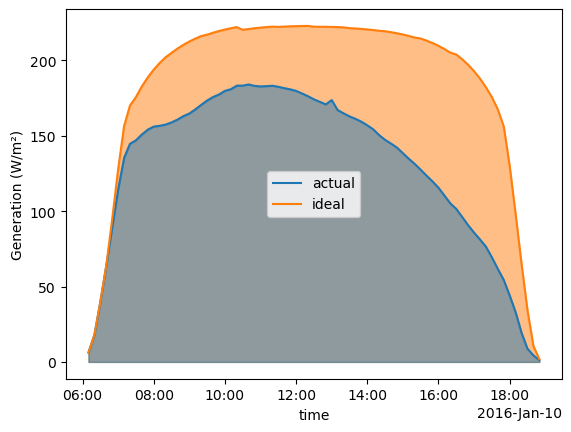

In [49]:
date = '2016-01-10'
fig, ax = plt.subplots()

# Plot the actual and ideal lines
actual = ds.actual.sel(time=date)
ideal = ds.ideal.sel(time=date)
ideal = xr.where(actual > ideal, actual, ideal)

# Plot the lines
actual.plot(ax=ax, label='actual', color='tab:blue')
ideal.plot(ax=ax, label='ideal', color='tab:orange')

# Fill under the curves
ax.fill_between(
    ideal.time, ideal, color='tab:orange', alpha=0.5
)
ax.fill_between(
    actual.time, actual, color='tab:blue', alpha=0.5
)


plt.ylabel('Generation (W/m²)')
plt.legend()

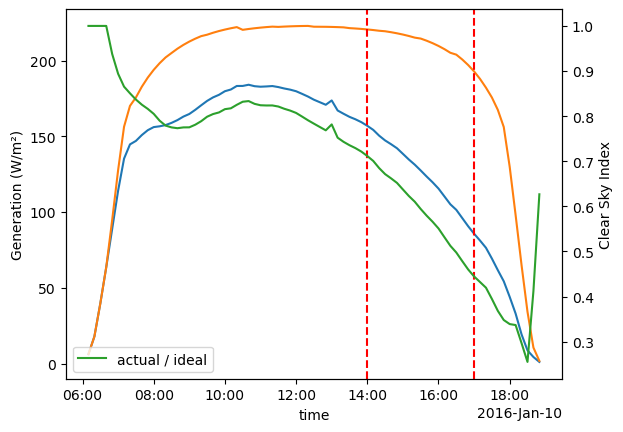

In [64]:
date = '2016-01-10'
start_time = f'{date}T14:00'
end_time = f'{date}T17:00'
fig, ax1 = plt.subplots()

# Plot actual and ideal on the first y-axis
ratio = actual / ideal
actual.plot(ax=ax1, label='actual', color='tab:blue')
ideal.plot(ax=ax1, label='ideal', color='tab:orange')
ax1.axvline(pd.to_datetime(start_time), color='red', linestyle='--')
ax1.axvline(pd.to_datetime(end_time), color='red', linestyle='--')

ax1.set_ylabel('Generation (W/m²)')
# ax1.legend(loc='center')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot ratio on the second y-axis
ratio.plot(ax=ax2, label='actual / ideal', color='tab:green')
ax2.set_ylabel('Clear Sky Index')
ax2.legend(loc='lower left')
plt.show()